# Activity Recognition

Dataset used:
[Wireless Sensor Data Mining (WISDM) Lab](http://www.cis.fordham.edu/wisdm/).

In [165]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from datetime import datetime

%matplotlib inline

rcParams['figure.figsize'] = 16, 9


CLASSES = 4
RANDOM_SEED = 42
L2_LOSS = 0.001
LEARNING_RATE = 0.005

## Defining the dataset
We don't want to predict upstairs/downstairs walking so we will not take these activities into account.

In [166]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()
df = df[df.activity != 'Upstairs']
df = df[df.activity != 'Downstairs']

## Overview of dataset
First rows from dataset

In [167]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


Random 10 rows from dataset

In [168]:
df_10 = df.sample(n=10)
print(df_10)

         user activity        timestamp     x-axis     y-axis    z-axis
342610     11  Walking    1746822276000   0.460000  13.950000 -1.184970
73352      29  Jogging    7609513103000   5.980000  -7.400000  6.932757
266001     18  Walking   18282192305000   7.250000  10.500000 -2.220117
628022     12  Jogging   17640452187000   5.790000   6.400000 -4.600000
123160     13  Jogging    2388362224000  -7.080000  15.320000 -4.794363
138859     15  Jogging     536932262000  19.570000  19.570000 -5.897611
1075473    19  Jogging  130183391573000   2.870000  -2.300000  6.170000
11654      17  Jogging   58252252306000   0.885323   5.979332  3.527670
637842     12  Jogging   18344871651000  -9.340000  19.530000  0.000000
210766     27  Jogging   11526772290000  -5.280000   6.510000 -7.777218


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874907 entries, 0 to 1098203
Data columns (total 6 columns):
user         874907 non-null int64
activity     874907 non-null object
timestamp    874907 non-null int64
x-axis       874907 non-null float64
y-axis       874907 non-null float64
z-axis       874907 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 46.7+ MB


## Exploration & Analysis

We will be most interested in columns: activity, x-axis, y-axis and z-axis.

Number of training examples by user

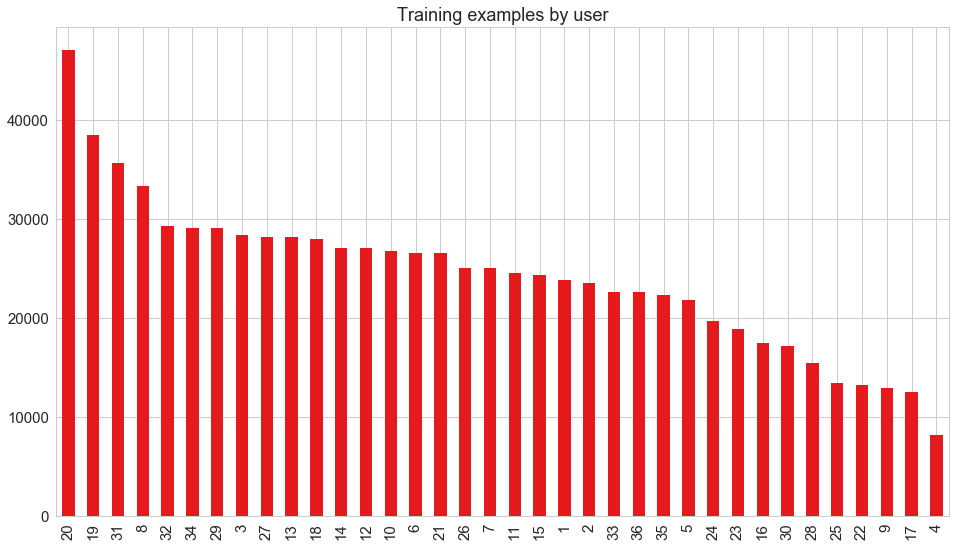

In [170]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user', colormap='Set1');

Number of training examples by activity

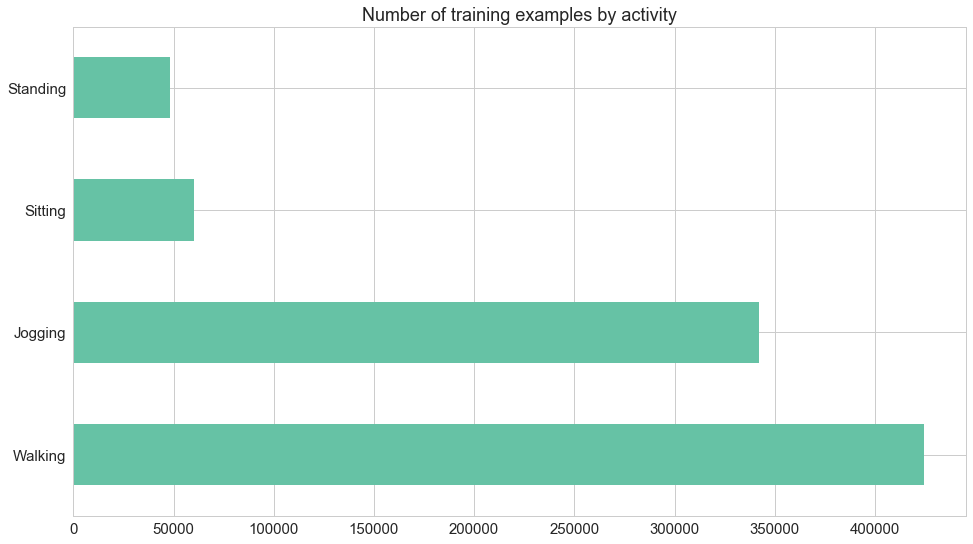

In [171]:
df['activity'].value_counts().plot(kind='barh', title='Number of training examples by activity', colormap='Set2');

In [172]:
def plot_activity(df, activity):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    data.plot(subplots=True, figsize=(16, 12), 
                     title=activity, colormap='Set1')

Axes for sitting activity

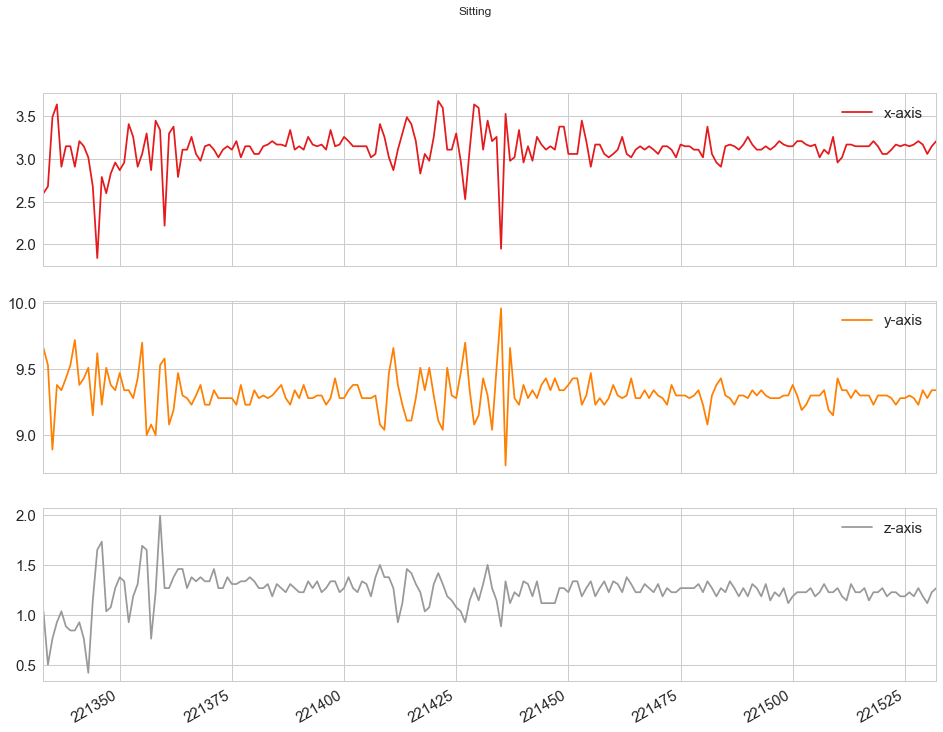

In [173]:
plot_activity(df, "Sitting")

Axes for standing activity

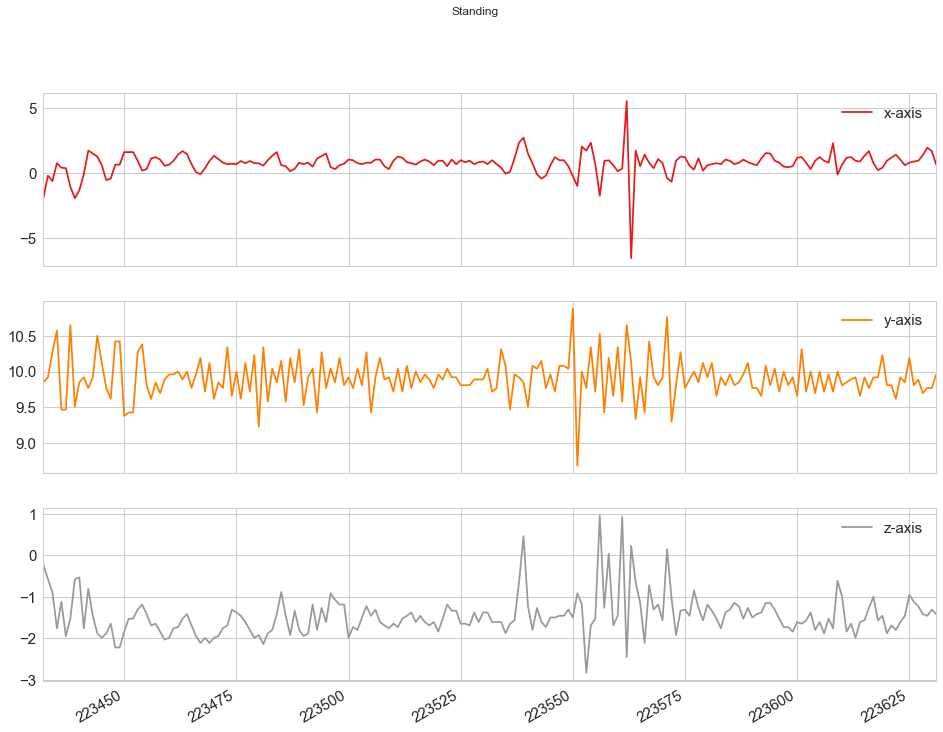

In [174]:
plot_activity(df, "Standing")

Axes for walking activity

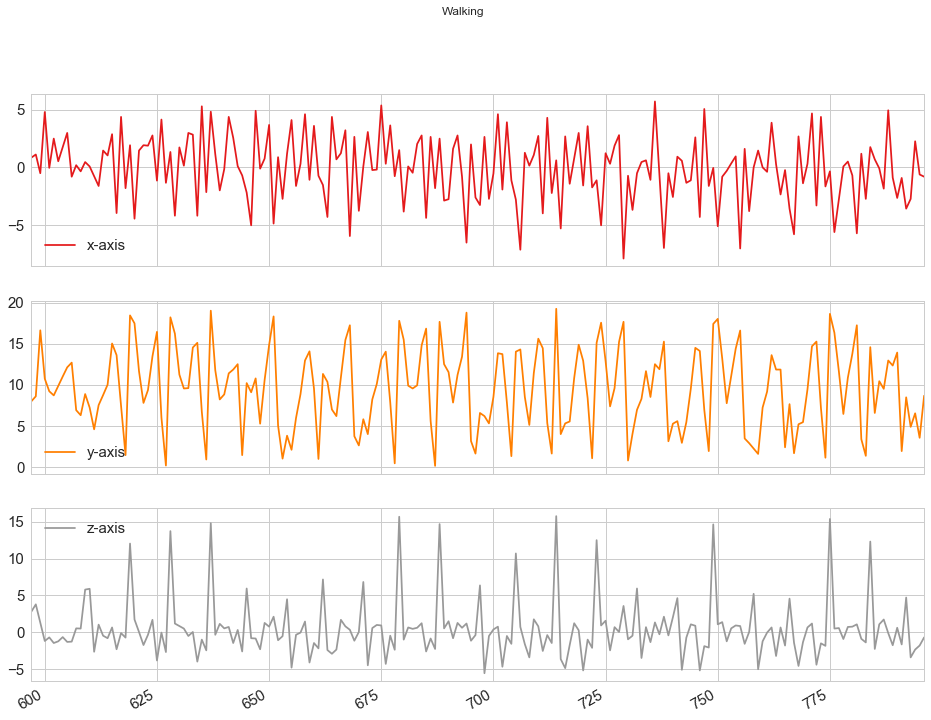

In [175]:
plot_activity(df, "Walking")

Axes for jogging activity

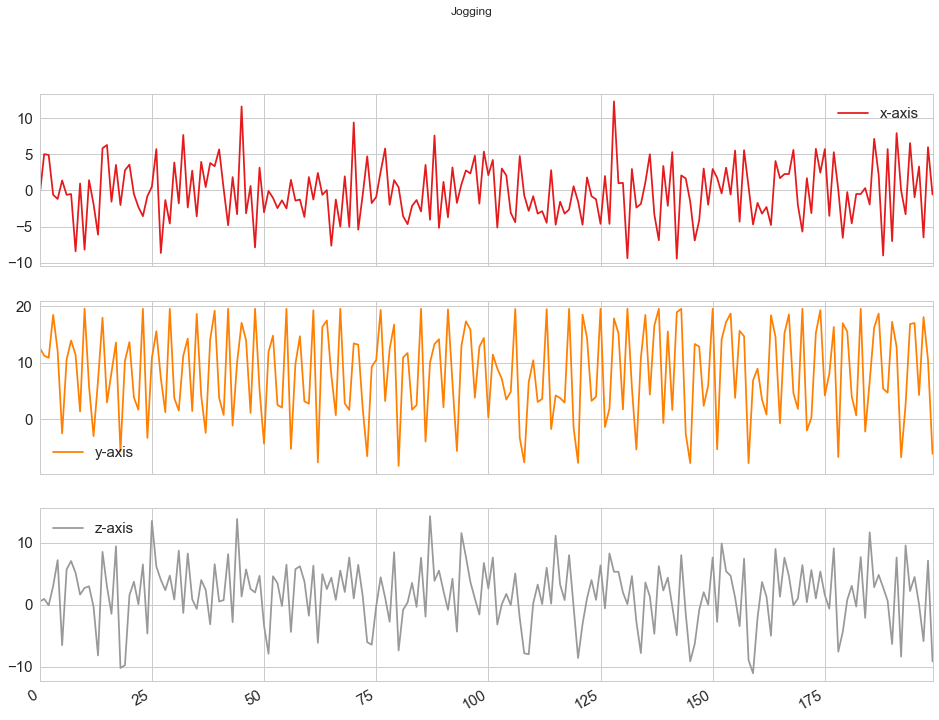

In [176]:
plot_activity(df, "Jogging")

## Data preprocessing

In [177]:
TIME_STEPS = 200
FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + TIME_STEPS]
    ys = df['y-axis'].values[i: i + TIME_STEPS]
    zs = df['z-axis'].values[i: i + TIME_STEPS]
    label = stats.mode(df['activity'][i: i + TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

/Users/gajel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [178]:
np.array(segments).shape

(43736, 3, 200)

In [179]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_STEPS, FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [180]:
reshaped_segments.shape

(43736, 200, 3)

In [181]:
labels[0]

array([ 1.,  0.,  0.,  0.], dtype=float32)

## Training and test sets

In [182]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [183]:
print(len(X_train))
print(len(y_train))
print(X_train.shape)
print(X_train[1][1:10])

34988
34988
(34988, 200, 3)
[[  6.21000004   7.3499999    5.17999983]
 [  5.86000013   0.34        -4.36999989]
 [-16.31999969 -12.72000027  -0.19      ]
 [  8.19999981  13.02000046   5.63000011]
 [  7.3499999    5.09000015  -1.99000001]
 [ -4.32999992   8.35000038   6.13000011]
 [  4.13999987   2.41000009  -5.40999985]
 [-10.11999989 -16.59000015  -6.92999983]
 [  0.56999999  12.86999989  11.32999992]]


In [184]:
len(X_test)

8748

## The model

We will use LSTM network (“LSTMs” – are a special kind of RNN, capable of learning long-term dependencies) to build our model with 2 fully connected layers. Number of classification classes is 4: sitting, standing, walking and jogging.

In [185]:
HIDDEN_UNITS = 64

In [186]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, TIME_STEPS, FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, CLASSES])

In [187]:
W = {
    'hidden': tf.Variable(tf.random_normal([FEATURES, HIDDEN_UNITS])),
    'output': tf.Variable(tf.random_normal([HIDDEN_UNITS, CLASSES]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([HIDDEN_UNITS], mean=1.0)),
    'output': tf.Variable(tf.random_normal([CLASSES]))
}

inputs = tf.transpose(X, [1, 0, 2])
inputs = tf.reshape(inputs, [-1, FEATURES])
hidden = tf.nn.relu(tf.matmul(inputs, W['hidden']) + biases['hidden'])
hidden = tf.split(hidden, TIME_STEPS, 0)

layers = [tf.contrib.rnn.BasicLSTMCell(HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
layers = tf.contrib.rnn.MultiRNNCell(layers)

outputs, _ = tf.contrib.rnn.static_rnn(layers, hidden, dtype=tf.float32)

last_output = outputs[-1]

pred_Y = tf.matmul(last_output, W['output']) + biases['output']

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [188]:
l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [189]:
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

## Training
The proper training phase.

In [190]:
EPOCHS = 50
BATCH_SIZE = 1024

saver = tf.train.Saver()

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

history = dict(train_loss=[], 
                 train_acc=[], 
                 test_loss=[], 
                 test_acc=[])

for i in range(1, EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1, BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, train_acc, train_loss = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, test_acc, test_loss = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    time = datetime.now()

    print(f'epoch: {i} test accuracy: {test_acc} loss: {test_loss}, time: {time}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.8508230447769165 loss: 0.7760392427444458, time: 2018-02-06 00:55:36.880487
epoch: 2 test accuracy: 0.9452446103096008 loss: 0.5508971810340881, time: 2018-02-06 00:57:05.214113
epoch: 3 test accuracy: 0.977709174156189 loss: 0.4467378556728363, time: 2018-02-06 00:58:32.657248
epoch: 4 test accuracy: 0.9725651741027832 loss: 0.41528522968292236, time: 2018-02-06 00:59:56.518127
epoch: 5 test accuracy: 0.978738009929657 loss: 0.3768691420555115, time: 2018-02-06 01:01:20.732435
epoch: 6 test accuracy: 0.9835391044616699 loss: 0.3402496576309204, time: 2018-02-06 01:02:44.647213
epoch: 7 test accuracy: 0.9890260696411133 loss: 0.309620201587677, time: 2018-02-06 01:04:08.362117
epoch: 8 test accuracy: 0.9893689751625061 loss: 0.28804558515548706, time: 2018-02-06 01:05:32.113379
epoch: 9 test accuracy: 0.9894832968711853 loss: 0.26791679859161377, time: 2018-02-06 01:06:56.042554
epoch: 10 test accuracy: 0.9697073698043823 loss: 0.3262256681919098, time: 2018-0

Saving predictions and training history to a file.

In [191]:
pickle.dump(predictions, open("pickle/predictions.p", "wb"))
pickle.dump(history, open("pickle/history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

Loading files to variables.

In [192]:
history = pickle.load(open("pickle/history.p", "rb"))
predictions = pickle.load(open("pickle/predictions.p", "rb"))

## Evaluation

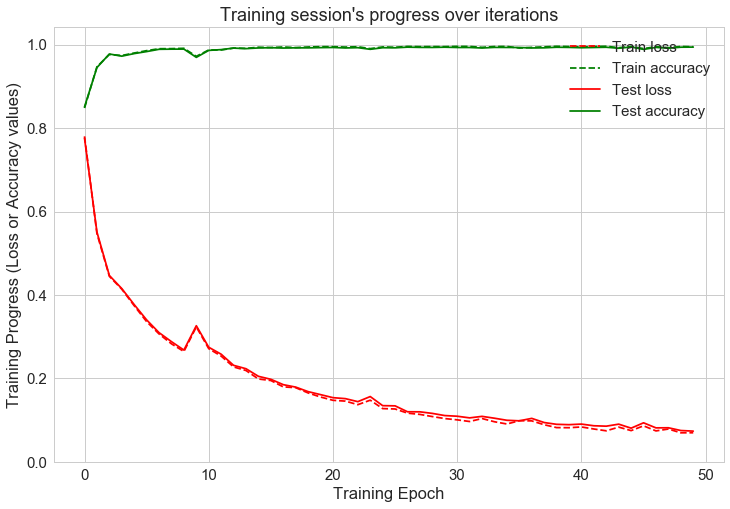

In [193]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [194]:
LABELS = ['Jogging', 'Sitting', 'Standing', 'Walking']

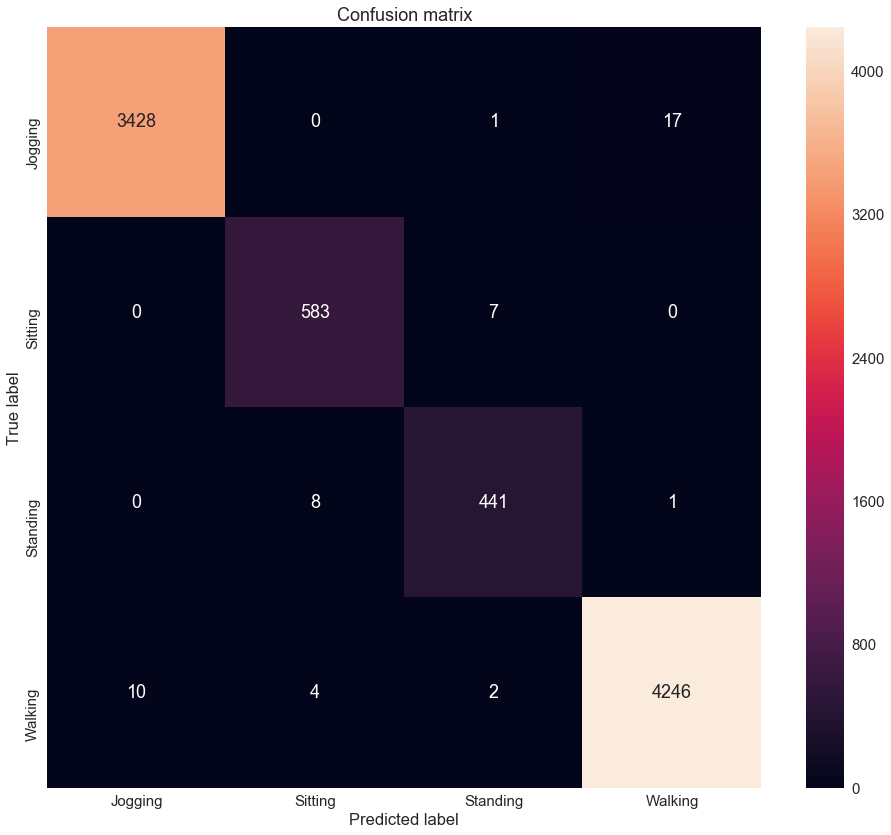

In [195]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Export the model

In [196]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'models/frozen_'+MODEL_NAME+'_4.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
